<a href="https://colab.research.google.com/github/bhavya6701/comp473-project/blob/main/comp473_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Artistic Style Transfer Using Convolutional Neural Networks
**Authors:** Shibin Koshy [40295019], Ruturajsinh Vihol [40154693], Bhavya Manjibhai Ruparelia [40164863]

## Imports

In [1]:
import os
import json
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from tqdm import tqdm
import warnings

from model_utils import (
    load_models,
    extract_features,
    gram_matrix,
    calculate_content_loss,
    calculate_style_loss,
)

from image_utils import load_image, tensor_to_image, plot_style_transfer, plot_images

In [2]:
# Filter out warnings
warnings.filterwarnings("ignore")

# Set the home directory
HOME = os.getcwd()

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Models

**VGG-16**: A convolutional neural network with 16 layers, popular for style transfer due to its ability to capture detailed hierarchical features across layers. Pre-trained on ImageNet, it offers a balance between depth and computational efficiency.

**VGG-19**: An extended version of VGG-16 with 19 layers, providing deeper feature representations. This model can capture more complex details, enhancing style extraction for artistic image synthesis.

<!-- **ResNet-50**: A 50-layer residual network with skip connections, which helps retain both high- and low-level features. This architecture is well-suited for extracting intricate textures and patterns in style transfer tasks. -->

In [3]:
# Load pre-trained models from torchvision
model_dict = load_models(device)

## Load Images

In [4]:
CONTENT_IMAGE_PATH = HOME + "/data/input_images/content11.jpeg"
STYLE_IMAGE_PATH = HOME + "/data/input_images/style12.jpg"

content = load_image(CONTENT_IMAGE_PATH).to(device)
style = load_image(STYLE_IMAGE_PATH, shape=content.shape[-2:]).to(device)

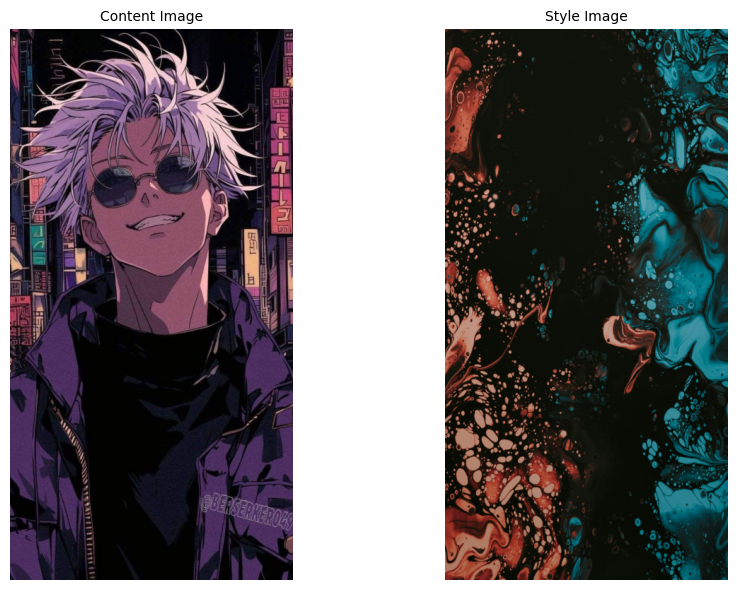

In [5]:
# Create a figure and set the title
plot_images(
    fig_size=(10, 6),
    rows=1,
    cols=2,
    images=[tensor_to_image(content), tensor_to_image(style)],
    titles=["Content Image", "Style Image"],
    axis="off",
)

## Loss Functions and Optimization

In [6]:
# Load the JSON file
with open("model_config.json", "r") as json_file:
    data = json.load(json_file)

# Extracting data into variables
layers = data["layers"]
model_style_weights = data["style_weights"]
content_loss_layer = data["content_layer"]
params = data["hyperparameters"]

# Define the hyperparameters
iterations = params["iters"]
checkpoints = params["ckpts"]
content_weight = params["alpha"]
style_weight = params["beta"]
lr = params["lr"]

## Training and Evaluation of Style Transfer Models

In [7]:
# Compute the content and style featuref for the content and style images using the VGG-16 and VGG-19 models
content_features = {
    "vgg-16": extract_features(content, model_dict["vgg-16"], layers["vgg-16"]),
    "vgg-19": extract_features(content, model_dict["vgg-19"], layers["vgg-19"]),
}
style_features = {
    "vgg-16": extract_features(style, model_dict["vgg-16"], layers["vgg-16"]),
    "vgg-19": extract_features(style, model_dict["vgg-19"], layers["vgg-19"]),
}

style_grams = {
    "vgg-16": {
        layer: gram_matrix(style_features["vgg-16"][layer])
        for layer in style_features["vgg-16"]
    },
    "vgg-19": {
        layer: gram_matrix(style_features["vgg-19"][layer])
        for layer in style_features["vgg-19"]
    },
}

In [15]:
#  Function for the style transfer algorithm
def style_transfer_algorithm(
    model_name,
    content_loss_layer,
    optim_name,
    iterations=1000,
    lr=0.01,
    checkpoints=10,
    alpha=1,
    beta=1e6,
):
    model = model_dict[model_name]
    model_content_features = content_features[model_name]
    model_style_features = style_features[model_name]

    if optim_name == "adam":
        # Initialize the target image - content image
        target = content.clone().requires_grad_(True).to(device)
        
        # Define the optimizer
        optimizer = optim.Adam([target], lr=lr)

        # Create a list to store the images and the total loss values
        images = [tensor_to_image(target.detach())]
        total_losses = []

        # Iterate through the steps
        for step in tqdm(range(1, iterations + 1)):
            # Extract the features from the target image
            target_features = extract_features(target, model, layers[model_name])

            # Calculate the content and style loss
            content_loss = calculate_content_loss(
                target_features, model_content_features, content_loss_layer
            )
            style_loss = calculate_style_loss(
                target_features, model_style_features, model_style_weights
            )

            # Compute the total loss
            total_loss = alpha * content_loss + beta * style_loss

            # Update the target image, zero the gradients, backpropagate, and step the optimizer
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Append the total loss to the list
            total_losses.append(total_loss.item())

            # Save the images at the specified checkpoints
            if step % (iterations // checkpoints) == 0:
                images.append(tensor_to_image(target.detach()))
    elif optim_name == "lbfgs":
        # Initialize the target image - noise
        target = torch.randn_like(content).requires_grad_(True).to(device)
        
        # Define the optimizer
        optimizer = optim.LBFGS([target])

        # Create a list to store the images and the total loss values
        images = [tensor_to_image(target.detach())]
        total_losses = []

        # Define the closure
        def closure():
            optimizer.zero_grad()

            # Extract the features from the target image
            target_features = extract_features(target, model, layers[model_name])

            # Calculate the content and style loss
            content_loss = calculate_content_loss(
                target_features, model_content_features, content_loss_layer
            )
            style_loss = calculate_style_loss(
                target_features, model_style_features, model_style_weights
            )

            # Compute the total loss
            total_loss = alpha * content_loss + beta * style_loss

            # Backpropagate
            total_loss.backward()

            # Append the total loss to the list
            total_losses.append(total_loss.item())

            return total_loss

        # Iterate through the steps
        for step in tqdm(range(1, iterations + 1)):
            optimizer.step(closure)

            # Save the images at the specified checkpoints
            if step % (iterations // checkpoints) == 0:
                images.append(tensor_to_image(target.detach()))            
    
    # print(
    #     f"Step {step}/{iterations} - Total loss: {total_losses[-1]:.16f}, "
    #     f"Content loss: {content_loss.item():.16f}, Style loss: {style_loss.item():.16f}"
    # )

    # Include the final image
    images.append(tensor_to_image(target.detach()))

    return images, total_losses

## VGG-16 Style Transfer

100%|██████████| 10/10 [03:00<00:00, 18.09s/it]


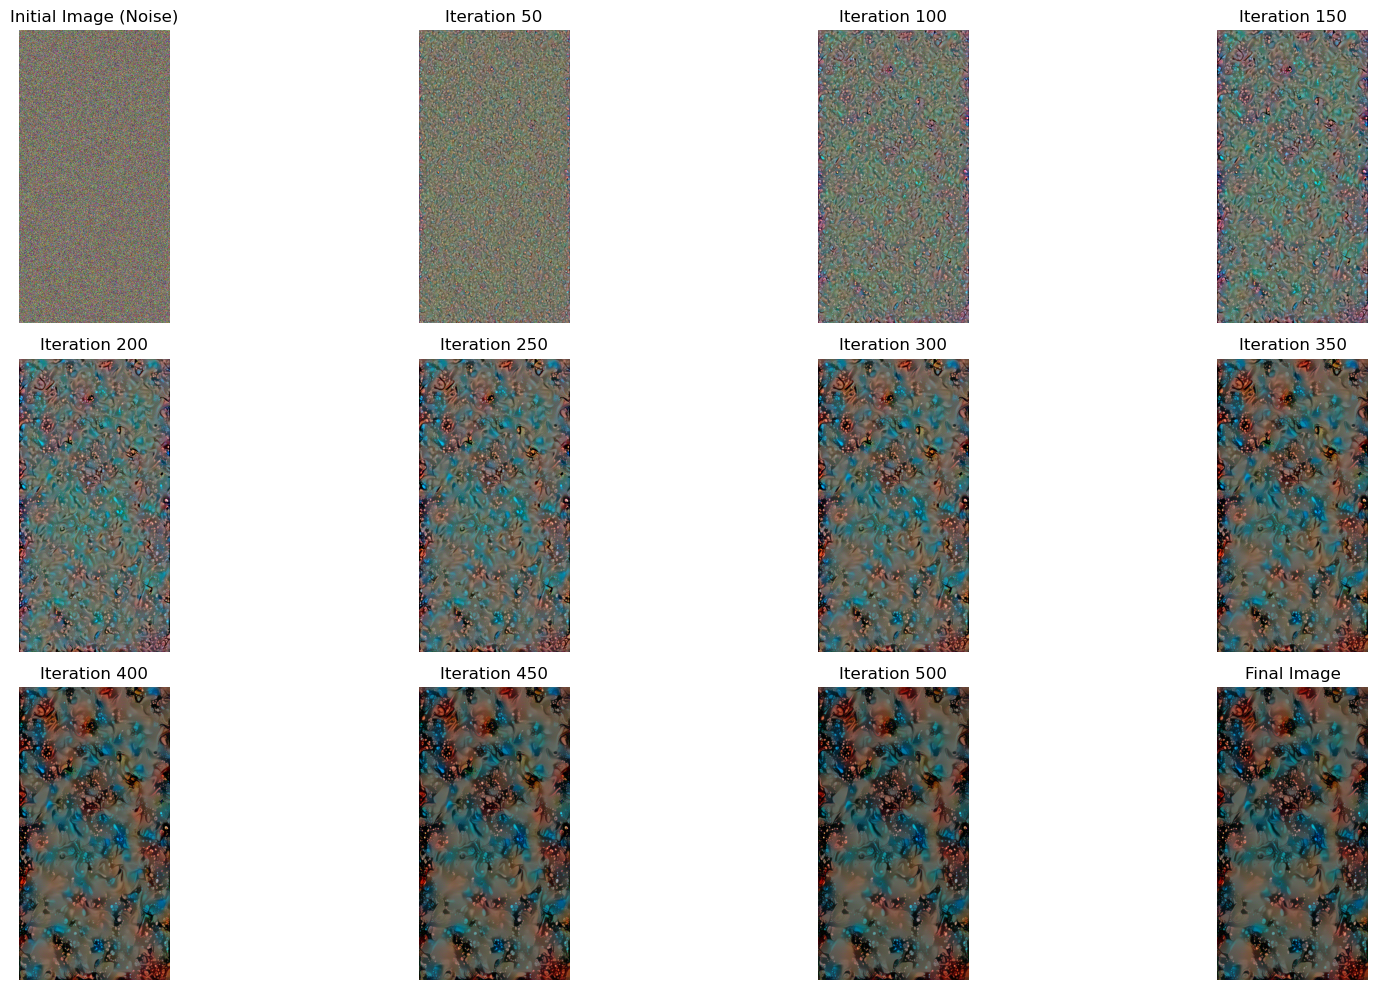

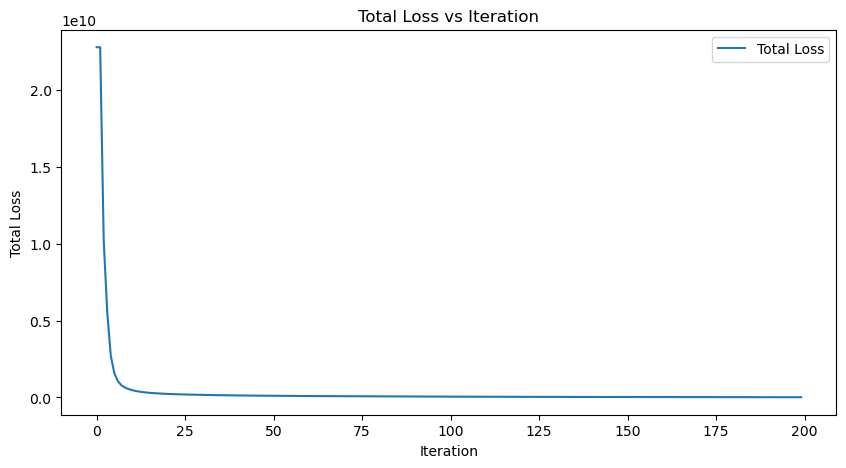

In [16]:
# Call the style transfer function for the VGG-16 model
saved_images, total_losses = style_transfer_algorithm(
    "vgg-16", content_loss_layer, "lbfgs", 10, lr, checkpoints, content_weight, style_weight
)

vgg16_output_image = saved_images[-1]

# Create a plot with the images and total loss values
plot_style_transfer(saved_images, total_losses, iterations, checkpoints)

## VGG-19 Style Transfer

In [ ]:
# Call the style transfer function for the VGG-19 model
saved_images, total_losses = style_transfer_algorithm(
    "vgg-19",
    content_loss_layer,
    "adam",
    iterations,
    lr,
    checkpoints,
    content_weight,
    style_weight,
)

vgg19_output_image = saved_images[-1]

# Create a plot with the images and total loss values
plot_style_transfer(saved_images, total_losses, iterations, checkpoints)

## Initial Content vs Final Style Transfer Image

In [ ]:
plot_images(
    fig_size=(20, 8),
    rows=2,
    cols=2,
    images=[
        tensor_to_image(content),
        tensor_to_image(style),
        vgg16_output_image,
        vgg19_output_image,
    ],
    titles=["Content Image", "Style Image", "VGG-16 Final Image", "VGG-19 Final Image"],
    axis="off",
)

## Content Layer Comparison

In [ ]:
compare_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
layer_images = []

# Iterate through the layers
for layer in compare_layers:
    print(f"Running style transfer for layer: {layer}")

    # Call the style transfer function for the VGG-19 model
    saved_images, total_losses = style_transfer_algorithm(
        "vgg-19", layer, "adam", iterations, lr, checkpoints, content_weight, style_weight
    )

    # Append the final image to the list
    layer_images.append(saved_images[-2])

# Create a plot with all the images obtained using different style_weight values
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image in enumerate(layer_images):
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Layer {compare_layers[i]}")

plt.tight_layout()
plt.show()


## Content Weight to Style Weight Ratio Analysis

In [ ]:
style_weights = [1e3, 1e4, 1e5, 1e6, 1e7]
output_images = []

# Call the style transfer function for the VGG-19 model
for sw in style_weights:
    print(f"Running style transfer algorithm with style weight = {sw}")
    saved_images, total_losses = style_transfer_algorithm(
        "vgg-19", "conv4_2", "adam", 500, lr, checkpoints, content_weight, sw
    )

    output_images.append(saved_images[-2])

# Create a plot with all the images obtained using different style weight values
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, image in enumerate(output_images):
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Style weight = {style_weights[i]}")

plt.tight_layout()
plt.show()